## Volatility Modeling: Forecasting

In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()


from arch import arch_model
import seaborn


from arch.__future__ import reindexing
reindex = True

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-10  50.500000  51.820000  50.500000  51.650002  41.124809  5967899
2021-05-11  51.740002  51.799999  50.849998  51.279999  40.830200  5468836
2021-05-12  51.279999  51.430000  50.590000  51.000000  40.607262  4035498
2021-05-13  51.000000  51.430000  50.130001  50.349998  40.089714  5492382
2021-05-14  50.610001  50.639999  49.509998  49.570000  39.468666  4308685


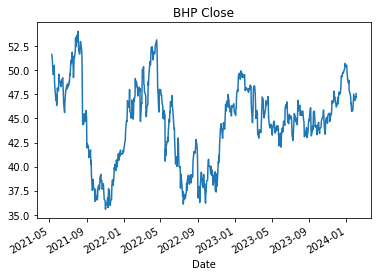

In [26]:
#Setting some arbitrary time period

end = dt.datetime.now()
start =end - dt.timedelta(days=1000)

# Importing some stock data
df = pdr.get_data_yahoo('BHP.AX', start, end)

print(df.head())


adjusted_close = df['Close']
adjusted_close.plot()
plt.title('BHP Close')
plt.show()





In [31]:
#### Splitting Data 
# Same values for importing time period for stock data
# splitting time period into half
end = dt.datetime.now()
start =end - dt.timedelta(days=1000)

mid = start + (dt.timedelta(days=1000)/2)

#Selecting df by Date time index
train =df.loc[:mid]
valid = df.loc[mid:]



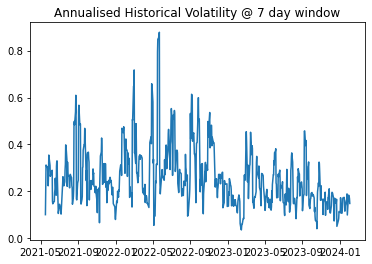

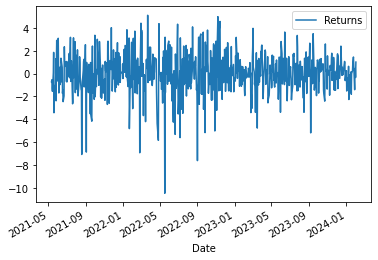

In [68]:
returns =100* df['Close'].pct_change().dropna()

# Log returns
lnReturns = np.log(df['Close']/df['Close'].shift(1))

# Trading Days
tdays = 252

# Window Size
window = 5


#Calculate Volatility
vol= df['Close'].pct_change().rolling(window).std()*(tdays**0.5)

plt.plot(vol)
plt.title('Annualised Historical Volatility @ 7 day window')
plt.show()


returns.name = 'Returns'
returns = returns.to_frame()
returns.plot();

### Forecasting

All models support three methods of forecasting:

Analytical: analytical forecasts are always available for the 1-step ahead forecast due to the structure of ARCH-type models. Multi-step analytical forecasts are only available for model which are linear in the square of the residual, such as GARCH or HARCH.

Simulation: simulation-based forecasts are always available for any horizon, although they are only useful for horizons larger than 1 since the first out-of-sample forecast from an ARCH-type model is always fixed. Simulation-based forecasts make use of the structure of an ARCH-type model to forward simulate using the assumed distribution of residuals, e.g., a Normal or Student’s t.


Bootstrap: bootstrap-based forecasts are similar to simulation based forecasts except that they make use of the standardized residuals from the actual data used in the estimation rather than assuming a specific distribution. Like simulation-base forecasts, bootstrap-based forecasts are only useful for horizons larger than 1. Additionally, the bootstrap forecasting method requires a minimal amount of in-sample data to use prior to producing the forecasts.


Any call to forecast() returns a ARCHModelForecast object with has 3 core attributes

mean - The forecast conditional mean.

variance - The forecast conditional variance.

residual_variance - The forecast conditional variance of residuals. This will differ from variance whenever the model has dynamics (e.g. an AR model) for horizons larger than 1.



### Analytical Forecast: GARCH(1,1)

In [32]:
#Selecting df by Date time index
#   train =df.loc[:mid]
#   valid = df.loc[mid:]

# returns on train data
returns_train = 100 * train['Close'].pct_change().dropna()


am = arch_model(returns_train, vol='Garch', p=1, o=0, q=1, dist='Normal')


res = am.fit(last_obs=mid)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1816.565134453945
Iteration:      2,   Func. Count:     17,   Neg. LLF: 757.8672675438161
Iteration:      3,   Func. Count:     23,   Neg. LLF: 743.6753179003321
Iteration:      4,   Func. Count:     28,   Neg. LLF: 821.2700372452769
Iteration:      5,   Func. Count:     34,   Neg. LLF: 742.4393513263991
Iteration:      6,   Func. Count:     39,   Neg. LLF: 5666.112757402757
Iteration:      7,   Func. Count:     47,   Neg. LLF: 742.2660606838856
Iteration:      8,   Func. Count:     52,   Neg. LLF: 742.2633896370297
Iteration:      9,   Func. Count:     57,   Neg. LLF: 742.2627873470551
Iteration:     10,   Func. Count:     62,   Neg. LLF: 742.2627800014136
Iteration:     11,   Func. Count:     67,   Neg. LLF: 742.2627792081614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 742.2627792081614
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2022-09-20  5.811195  5.817741  5.824273  5.830792  5.837297


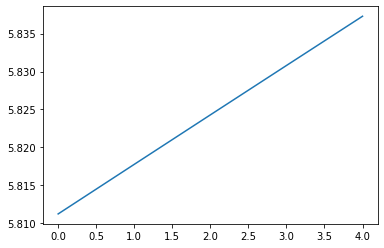

In [42]:
forecasts = res.forecast(horizon=5)

#forecasts.variance[mid:].plot()
#plt.show()
# These commands will not work as forecasts are stored in df with h1, h2 .... in a different column

#df_vol = forecasts.variance.stack().reset_index()
#df_vol.rename( columns={0 :'var'}, inplace=True )

#plt.plot(df_vol['var'])
#plt.plot()
#plt.show()

print(forecasts.variance)

df_vol = forecasts.variance.stack().reset_index()
df_vol.rename( columns={0 :'var'}, inplace=True )
plt.plot(df_vol['var'])
plt.plot()
plt.show()


### TARCH/ZARCH Forecasting

In [44]:

am = arch_model(returns_train, p=1, o=1, q=1, power=1.0, dist="StudentsT")
res = am.fit(update_freq=5)


Iteration:      5,   Func. Count:     43,   Neg. LLF: 729.5081987654875
Iteration:     10,   Func. Count:     79,   Neg. LLF: 728.1847900377627
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.1847760952397
            Iterations: 13
            Function evaluations: 99
            Gradient evaluations: 13


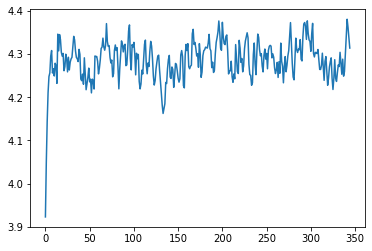

In [69]:
forecasts = res.forecast(horizon=len(valid),method='simulation')

df_vol = forecasts.variance.stack().reset_index()
df_vol.rename( columns={0 :'var'}, inplace=True )
plt.plot(df_vol['var'])

plt.show()



